## 1.Get ready

In [1]:
import glob
import matplotlib.image as mpimg
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

img_str_vehicles = glob.glob('img_train/vehicles/*/*.png')
img_str_nonvehicles = glob.glob('img_train/non-vehicles/*/*.png')

## 2.Define a function to convert the color and resize the image

In [2]:
def color_cov(img, color_space='RGB', size=(32, 32)):
    '''
    convert color and resize the image
    '''
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    features = cv2.resize(feature_image, size)
    return features

## 3.Explore color spaces

(64, 64, 3)


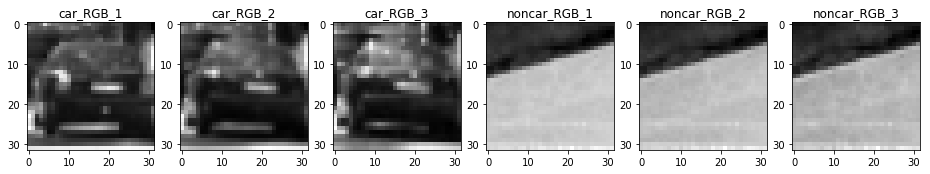

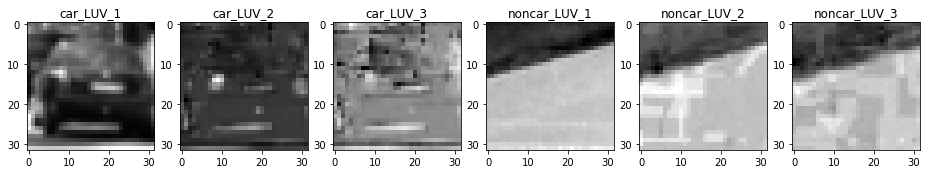

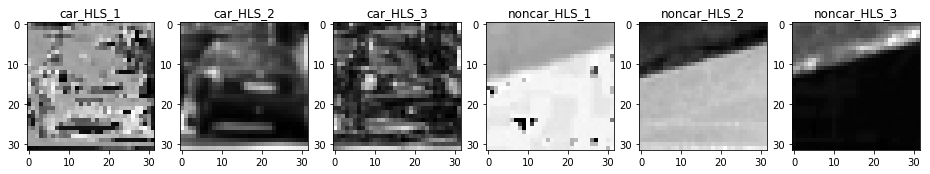

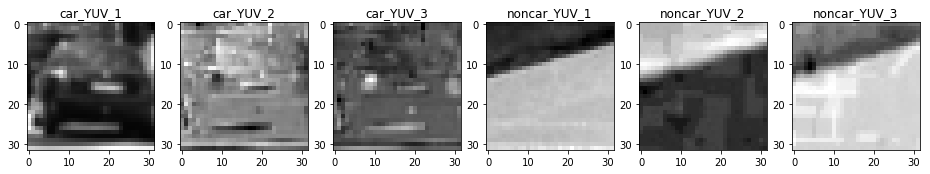

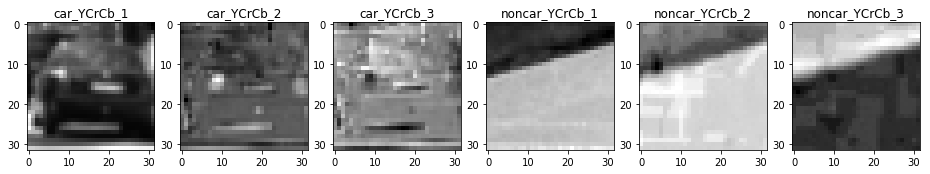

In [3]:
# Show different color space
from random import choice

# Read car and non-car image randomly
img_car = mpimg.imread(choice(img_str_vehicles))
img_noncar = mpimg.imread(choice(img_str_nonvehicles))

print(img_car.shape)

# Show the images
for cspace in ['RGB', 'LUV', 'HLS', 'YUV', 'YCrCb']:
    cov_car = color_cov(img_car, cspace)
    cov_noncar = color_cov(img_noncar, cspace)

    plt.figure(figsize=(16,7))
    for i in range(0,3):
        plt.subplot(1,6,i+1)
        plt.title('car_'+cspace+'_'+str(i+1))
        plt.imshow(cov_car[:,:,i],cmap='gray')
    for i in range(3,6):
        plt.subplot(1,6,i+1)
        plt.title('noncar_'+cspace+'_'+str(i-2))
        plt.imshow(cov_noncar[:,:,i-3],cmap='gray')


## 4.Explor the hog

In [4]:
from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    '''
    get HOG features
    '''
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm='L1',
                                  transform_sqrt=False, 
                                  visualise=True, feature_vector=False)

        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient,
                                pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm='L1',
                                  transform_sqrt=False, 
                                  visualise=False, feature_vector=True)
        return features


img_car = mpimg.imread(choice(img_str_vehicles))
img_noncar = mpimg.imread(choice(img_str_nonvehicles))

gray_car = cv2.cvtColor(img_car, cv2.COLOR_RGB2YCrCb)[:,:,0]
gray_noncar = cv2.cvtColor(img_noncar, cv2.COLOR_RGB2YCrCb)[:,:,0]

D:\Program\Anaconda3\envs\selfdriving\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


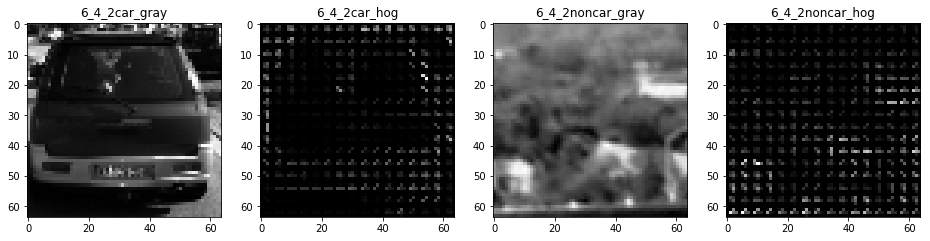

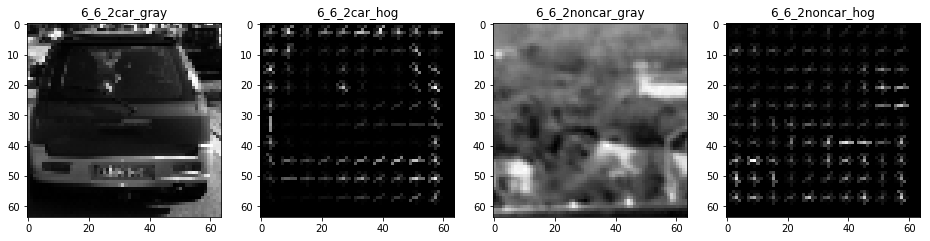

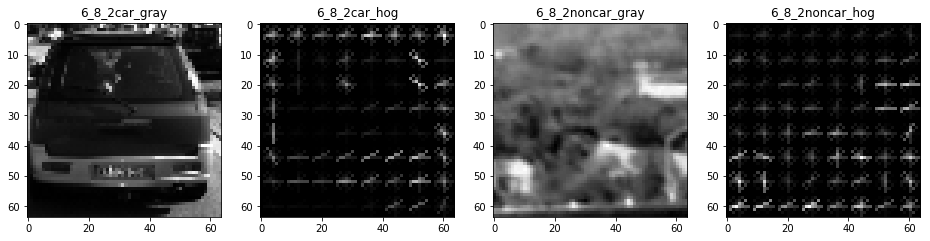

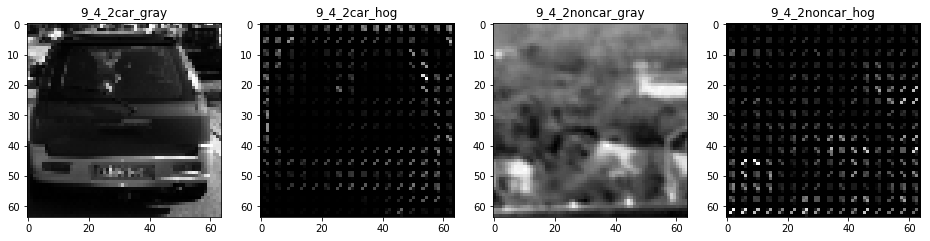

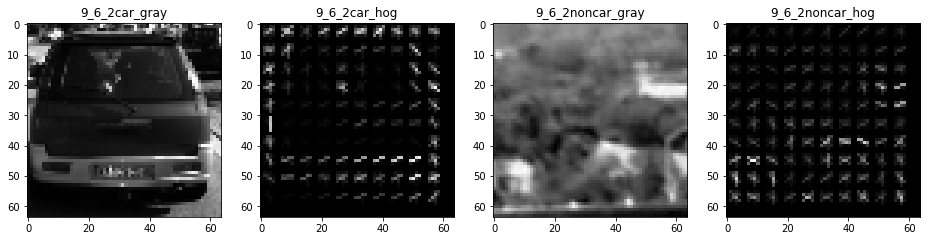

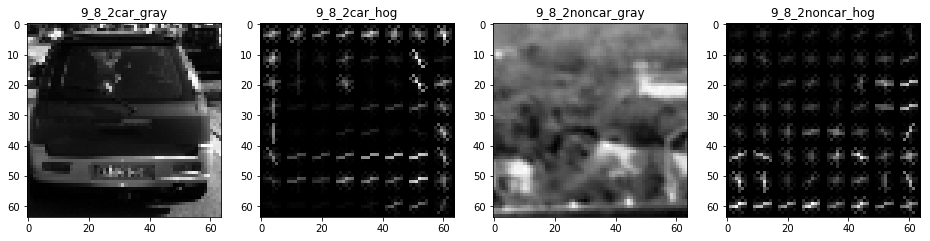

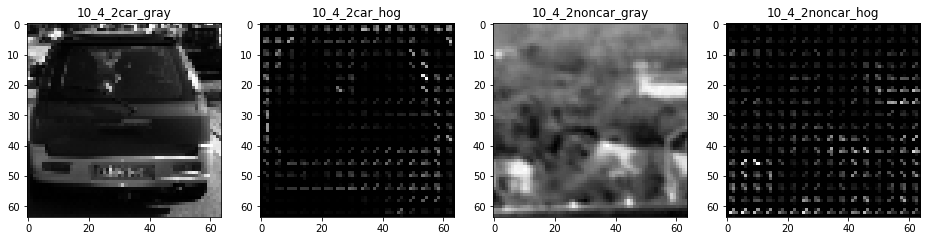

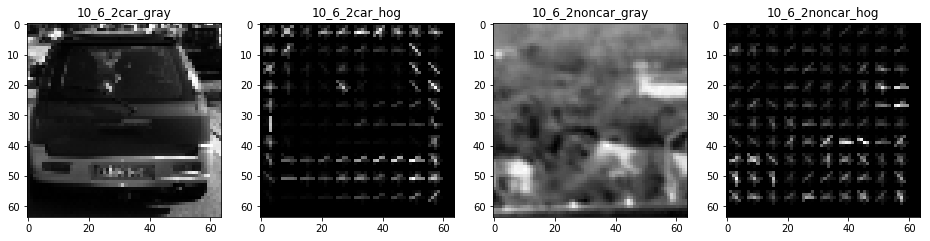

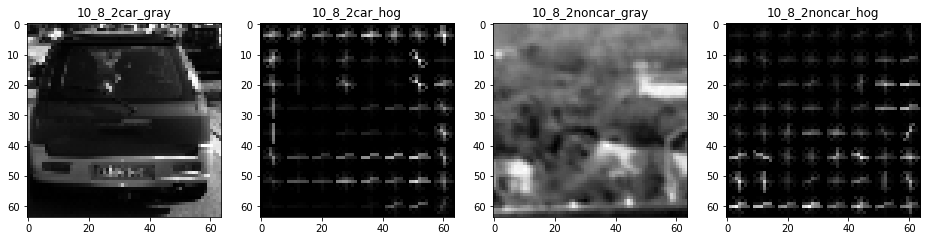

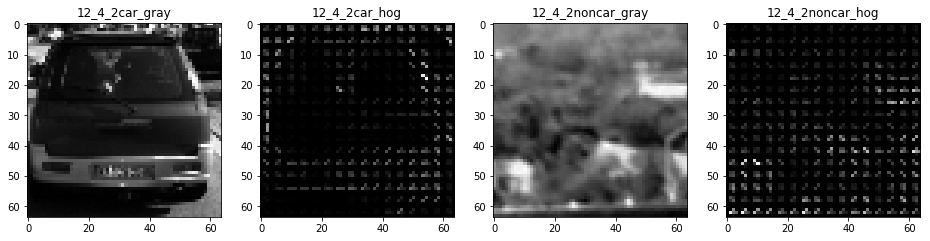

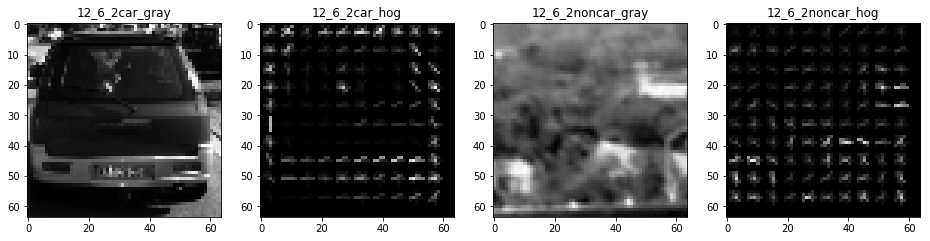

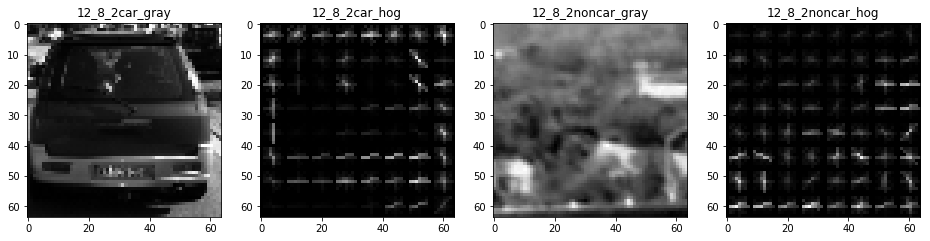

In [5]:


cell_per_block = 2
for orient in [6,9,10,12]:
    for pix_per_cell in [4,6,8]:
        
        hog_fea_car, hog_img_car = get_hog_features(gray_car, orient, pix_per_cell, cell_per_block, vis=True)
        hog_fea_noncar, hog_img_noncar = get_hog_features(gray_noncar, orient, pix_per_cell, cell_per_block, vis=True)
            
        titlestr=str(orient)+'_'+str(pix_per_cell)+'_'+str(cell_per_block)
            
        plt.figure(figsize=(16,7))
        plt.subplot(1,4,1)
        plt.title(titlestr+'car_gray')
        plt.imshow(gray_car,cmap='gray')
        plt.subplot(1,4,2)
        plt.title(titlestr+'car_hog')
        plt.imshow(hog_img_car,cmap='gray')
        plt.subplot(1,4,3)
        plt.title(titlestr+'noncar_gray')
        plt.imshow(gray_noncar,cmap='gray')
        plt.subplot(1,4,4)
        plt.title(titlestr+'noncar_hog')
        plt.imshow(hog_img_noncar,cmap='gray')

## 5.Make features

In [6]:
#define hog parameters
orient = 12
pix_per_cell = 8
cell_per_block = 2


In [7]:
from lesson_function import *

def ex_features(img, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block):
    '''
    Get features from image
    '''
    #Reading images
    image = mpimg.imread(img)
    #Convert color space
    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    #Get hog features
    hog_features_0 = get_hog_features(feature_image[:,:,0], orient, pix_per_cell, cell_per_block, feature_vec=True)
    hog_features_1 = get_hog_features(feature_image[:,:,1], orient, pix_per_cell, cell_per_block, feature_vec=True)
    hog_features_2 = get_hog_features(feature_image[:,:,2], orient, pix_per_cell, cell_per_block, feature_vec=True)
    #Get spatially binned color
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    #Get histograms of color 
    hist_features = color_hist(feature_image, nbins=hist_bins)
    #Combinate features
    features = np.hstack((spatial_features, hist_features, hog_features_0, hog_features_1, hog_features_2))
    
    return features

## 6.Train classifier

In [8]:
# Get features from all car images and non-car images

x_features = []

kk=0
for img_str_car in img_str_vehicles:
    kk=kk+1
    x_features.append(ex_features(img_str_car))
    if kk%500==0:
        print(kk,end=',')
kk=0     
for img_str_noncar in img_str_nonvehicles:
    kk=kk+1
    x_features.append(ex_features(img_str_noncar))
    if kk%500==0:
        print(kk,end=',')
        
x_features = np.array(x_features).astype(np.float32)
print(x_features.shape)


D:\Program\Anaconda3\envs\selfdriving\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,(17760, 10224)


In [9]:
# Make label data
Y_car = np.ones(len(img_str_vehicles))
Y_noncar = np.zeros(len(img_str_nonvehicles))
Y = np.hstack((Y_car, Y_noncar))
print(Y.shape)
print(np.sum(Y))

(17760,)
8792.0


In [10]:
# Splite the features and labels for trainign and testing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_scaler = StandardScaler().fit(x_features)
X_scaled = X_scaler.transform(x_features)
x_features = [] #release the memory
rand_state = np.random.randint(0, 100)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=rand_state)
X_scaled = [] #release the memory
Y = [] #release the memory

In [11]:
# Use the training data to trian a linearSVC
import time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
#svc = SVC(kernel='rbf')
svc = LinearSVC()
#parameters = {'kernel':['poly'],'C':[ 0.1]}

t1=time.time()
#clf = GridSearchCV(svc, parameters, n_jobs=1)
#clf.fit(X_train, Y_train)
svc.fit(X_train, Y_train)
t2 = time.time()
print(t2-t1)

# Validate the classifier with test data
svc.score(X_test,Y_test)





7.7641441822052


0.99239864864864868

## 7.Save values to pk file

In [12]:
import pickle
f = open('svm.pk','wb')
pickle.dump({'scaler':X_scaler,'svc':svc,'orient':orient,'pix_per_cell':pix_per_cell,'cell_per_block':cell_per_block}, f)
pickle.dump({'svc':svc,'orient':orient,'pix_per_cell':pix_per_cell,'cell_per_block':cell_per_block}, f)
f.close()

X_train=[]
Y_train=[]
X_test=[]
Y_test=[]

